In [9]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing batch attack results
results_dir = 'batch_attack_results'

# 1. List all summary and per-run CSVs
all_csvs = glob.glob(os.path.join(results_dir, '*.csv'))
all_csvs

['batch_attack_results/librispeech-v2-THE_YOUNG_KID_JUMPED_THE_RUSTY_GATE-260-123440-0008.csv',
 'batch_attack_results/an4-v1-THE_PENNANT_WAVED_WHEN_THE_WIND_BLEW-5683-32866-0027.csv',
 'batch_attack_results/ted-v1-A_CRAMP_IS_NO_SMALL_DANGER_ON_A_SWIM-4507-16021-0015.csv',
 'batch_attack_results/an4-v2-THE_HEART_BEAT_STRONGLY_AND_WITH_FIRM_STROKES-260-123440-0008.csv',
 'batch_attack_results/an4-v1-A_YACHT_SLID_AROUND_THE_POINT_INTO_THE_BAY-5683-32866-0027.csv',
 'batch_attack_results/ted-v1-THE_HEART_BEAT_STRONGLY_AND_WITH_FIRM_STROKES-4507-16021-0015.csv',
 'batch_attack_results/librispeech-v2-THE_JUICE_OF_LEMONS_MAKES_FINE_PUNCH-1089-134691-0005.csv',
 'batch_attack_results/an4-v2-A_CRAMP_IS_NO_SMALL_DANGER_ON_A_SWIM-260-123440-0008.csv',
 'batch_attack_results/an4-v1-THE_HEART_BEAT_STRONGLY_AND_WITH_FIRM_STROKES-260-123440-0008.csv',
 'batch_attack_results/ted-v1-THE_YOUNG_KID_JUMPED_THE_RUSTY_GATE-4507-16021-0015.csv',
 'batch_attack_results/librispeech-v1-THE_JUICE_OF_LEMONS_MAKE

In [10]:
# combine all of the per_run_csvs into a single dataframe
dfs = [pd.read_csv(f) for f in all_csvs]
df_all = pd.concat(dfs, ignore_index=True)
print(df_all.head())
print(f"Combined DataFrame shape: {df_all.shape}")

                                        adv_wav_path  \
0  batch_attack_results/librispeech-v2-THE_YOUNG_...   
1  batch_attack_results/an4-v1-THE_PENNANT_WAVED_...   
2  batch_attack_results/ted-v1-A_CRAMP_IS_NO_SMAL...   
3  batch_attack_results/an4-v2-THE_HEART_BEAT_STR...   
4  batch_attack_results/an4-v1-A_YACHT_SLID_AROUN...   

                             input_wav  \
0  processed_sound/260-123440-0008.wav   
1  processed_sound/5683-32866-0027.wav   
2  processed_sound/4507-16021-0015.wav   
3  processed_sound/260-123440-0008.wav   
4  processed_sound/5683-32866-0027.wav   

                                 target_sentence target_model target_version  \
0            THE YOUNG KID JUMPED THE RUSTY GATE  librispeech             v2   
1           THE PENNANT WAVED WHEN THE WIND BLEW          an4             v1   
2           A CRAMP IS NO SMALL DANGER ON A SWIM          ted             v1   
3  THE HEART BEAT STRONGLY AND WITH FIRM STROKES          an4             v2   
4     A YA

In [11]:
import ast
import numpy as np
import matplotlib.pyplot as plt

# --- Target Loss ---
loss_lists = [ast.literal_eval(x) for x in df_all["target_loss_hist"].dropna()]
max_len = max(len(lst) for lst in loss_lists)
loss_array = np.full((len(loss_lists), max_len), np.nan)
for i, lst in enumerate(loss_lists):
    loss_array[i, :len(lst)] = lst
mean_target_loss = np.nanmean(loss_array, axis=0)

# --- Ensemble Loss ---
ensemble_loss_lists = [ast.literal_eval(x) for x in df_all["ensemble_loss_hists"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_loss_lists)
max_steps = max(len(model) for run in ensemble_loss_lists for model in run)
ens_loss_array = np.full((len(ensemble_loss_lists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_loss_lists):
    for j, model in enumerate(run):
        ens_loss_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_loss = np.nanmean(ens_loss_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(mean_target_loss, marker='o', label='Mean Target Loss')
plt.plot(mean_ensemble_loss, marker='s', label='Mean Ensemble Loss')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Loss')
plt.title('Mean Loss at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'target_loss_hist'

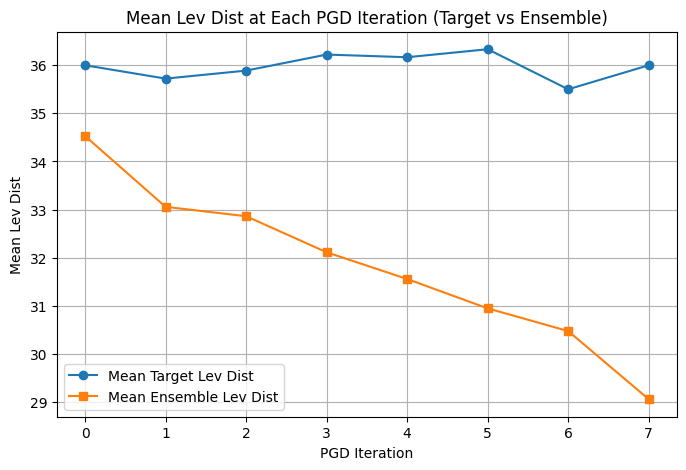

In [12]:
# --- Target Lev Dist ---
target_lev_dists = [ast.literal_eval(x) for x in df_all["target_lev_dists"].dropna()]
max_len = max(len(lst) for lst in target_lev_dists)
target_lev_array = np.full((len(target_lev_dists), max_len), np.nan)
for i, lst in enumerate(target_lev_dists):
    target_lev_array[i, :len(lst)] = lst
mean_target_lev = np.nanmean(target_lev_array, axis=0)

# --- Ensemble Lev Dist ---
ensemble_lev_dists = [ast.literal_eval(x) for x in df_all["ensemble_lev_dists"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_lev_dists)
max_steps = max(len(model) for run in ensemble_lev_dists for model in run)
ens_lev_array = np.full((len(ensemble_lev_dists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_lev_dists):
    for j, model in enumerate(run):
        ens_lev_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_lev = np.nanmean(ens_lev_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(mean_target_lev, marker='o', label='Mean Target Lev Dist')
plt.plot(mean_ensemble_lev, marker='s', label='Mean Ensemble Lev Dist')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Lev Dist')
plt.title('Mean Lev Dist at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

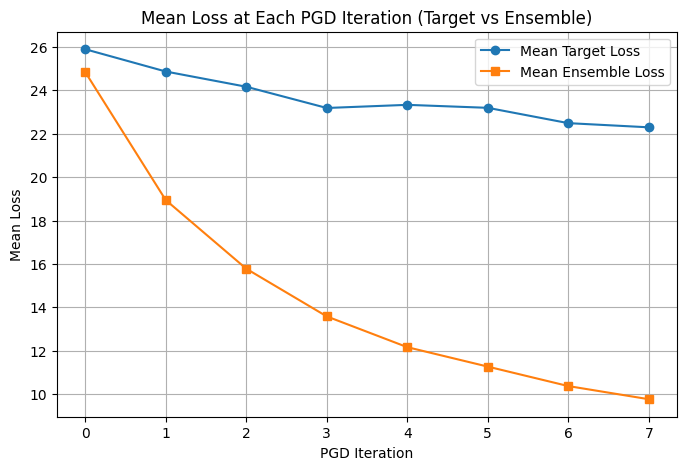

In [15]:
# --- Target Loss ---
target_loss_histories = [ast.literal_eval(x) for x in df_all["target_losses"].dropna()]
max_len = max(len(lst) for lst in target_loss_histories)
target_loss_array = np.full((len(target_loss_histories), max_len), np.nan)
for i, lst in enumerate(target_loss_histories):
    target_loss_array[i, :len(lst)] = lst
mean_target_loss = np.nanmean(target_loss_array, axis=0)

# --- Ensemble Loss ---
ensemble_loss_histories = [ast.literal_eval(x) for x in df_all["ensemble_losses"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_loss_histories)
max_steps = max(len(model) for run in ensemble_loss_histories for model in run)
ens_loss_array = np.full((len(ensemble_loss_histories), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_loss_histories):
    for j, model in enumerate(run):
        ens_loss_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_loss = np.nanmean(ens_loss_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(mean_target_loss, marker='o', label='Mean Target Loss')
plt.plot(mean_ensemble_loss, marker='s', label='Mean Ensemble Loss')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Loss')
plt.title('Mean Loss at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

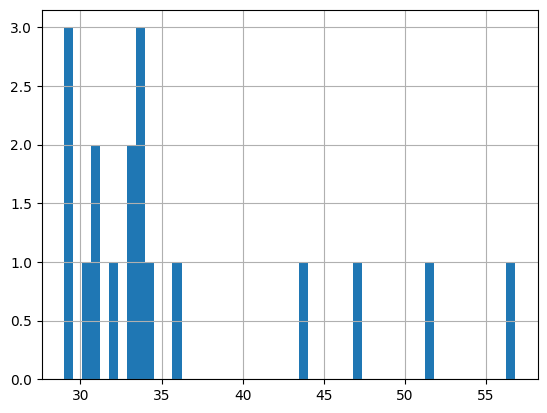

In [19]:
# First parse out the average of the last five levenshtein distances for the target
df_all['final_target_lev_dist'] = df_all['target_lev_dists'].apply(lambda x: np.mean(ast.literal_eval(x)[-5:]))

# Histogram of the final target levenshtein distances
df_all['final_target_lev_dist'].hist(bins=50)
plt.show()

In [16]:
df_all

,adv_wav_path,input_wav,target_sentence,target_model,target_version,ensemble_models,attack_params,target_pred,target_lev_dists,ensemble_lev_dists,target_losses,ensemble_losses,max_db_diff
0,batch_attack_results/librispeech-v2-THE_YOUNG_...,processed_sound/260-123440-0008.wav,THE YOUNG KID JUMPED THE RUSTY GATE,librispeech,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",I'LL TRY IF I KNOW ALL THE THINGS I USED TO NEL,"[33, 35, 33, 34, 35, 34, 31, 33]","[[25, 26, 26, 22, 24, 22, 24, 22], [35, 30, 27...","[34.25948715209961, 29.979896545410156, 26.380...","[[15.1004638671875, 11.397059440612793, 9.4230...",0.008590
1,batch_attack_results/an4-v1-THE_PENNANT_WAVED_...,processed_sound/5683-32866-0027.wav,THE PENNANT WAVED WHEN THE WIND BLEW,an4,v1,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",V RO I U R E O R U NI C IR,"[29, 29, 29, 29, 29, 29, 29, 29]","[[42, 44, 39, 43, 36, 36, 32, 32], [35, 33, 30...","[11.712661743164062, 11.536199569702148, 11.49...","[[49.53019332885742, 38.28373718261719, 33.336...",0.022984
2,batch_attack_results/ted-v1-A_CRAMP_IS_NO_SMAL...,processed_sound/4507-16021-0015.wav,A CRAMP IS NO SMALL DANGER ON A SWIM,ted,v1,"[{""training_set"": ""an4"", ""version"": ""v1""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",SINCE WHER HAS LORLDS TO SO FUNDTISED REDISINES,"[30, 28, 31, 29, 29, 30, 28, 29]","[[30, 28, 29, 30, 28, 29, 29, 28], [29, 27, 26...","[12.092660903930664, 11.524734497070312, 12.00...","[[9.25838565826416, 8.66250991821289, 8.115129...",0.020089
3,batch_attack_results/an4-v2-THE_HEART_BEAT_STR...,processed_sound/260-123440-0008.wav,THE HEART BEAT STRONGLY AND WITH FIRM STROKES,an4,v2,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",HOH INE EY NINE O ON EA NINE TEIN OH,"[34, 33, 33, 33, 33, 34, 35, 33]","[[38, 37, 36, 36, 32, 35, 33, 32], [38, 35, 39...","[12.213180541992188, 12.178717613220215, 12.26...","[[31.57174301147461, 23.770578384399414, 17.99...",0.008273
4,batch_attack_results/an4-v1-A_YACHT_SLID_AROUN...,processed_sound/5683-32866-0027.wav,A YACHT SLID AROUND THE POINT INTO THE BAY,an4,v1,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",V RO I U R E O R U NI C IR,"[32, 30, 31, 31, 31, 31, 31, 31]","[[44, 42, 38, 37, 37, 36, 37, 32], [39, 35, 33...","[8.889790534973145, 8.862767219543457, 8.77860...","[[42.63605499267578, 33.4556999206543, 27.4883...",0.020552
5,batch_attack_results/ted-v1-THE_HEART_BEAT_STR...,processed_sound/4507-16021-0015.wav,THE HEART BEAT STRONGLY AND WITH FIRM STROKES,ted,v1,"[{""training_set"": ""an4"", ""version"": ""v1""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",SINCE WHET HAS LERLSDYO FUNISED MVEDISINES,"[36, 34, 35, 34, 35, 35, 32, 34]","[[35, 35, 34, 34, 35, 33, 32, 32], [34, 30, 32...","[11.381012916564941, 11.128096580505371, 11.02...","[[9.266073226928711, 8.806324005126953, 8.3230...",0.024664
6,batch_attack_results/librispeech-v2-THE_JUICE_...,processed_sound/1089-134691-0005.wav,THE JUICE OF LEMONS MAKES FINE PUNCH,librispeech,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",WHOHSE FEIT ARE AS THE FEET OF HEARTS AND UNDE...,"[60, 60, 56, 58, 55, 59, 57, 55]","[[36, 34, 30, 32, 37, 35, 29, 28], [57, 53, 51...","[52.526390075683594, 49.332374572753906, 47.44...","[[24.28938865661621, 19.92934226989746, 16.124...",0.022597
7,batch_attack_results/an4-v2-A_CRAMP_IS_NO_SMAL...,processed_sound/260-123440-0008.wav,A CRAMP IS NO SMALL DANGER ON A SWIM,an4,v2,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",HOH INE EHT FINE O ON A NINE E TEIO OH,"[28, 28, 30, 29, 29, 28, 30, 29]","[[30, 29, 32, 34,